[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/HSinger04/VOGUE-Reimplementation/blob/main/cryu854/Image2Latent.ipynb)

In [1]:
%cd /content
!git clone https://github.com/HSinger04/VOGUE-Reimplementation

/content
Cloning into 'VOGUE-Reimplementation'...
remote: Enumerating objects: 179, done.
remote: Counting objects: 100% (179/179), done.
remote: Compressing objects: 100% (178/178), done.
remote: Total 482 (delta 116), reused 0 (delta 0), pack-reused 303
Receiving objects: 100% (482/482), 84.29 MiB | 33.34 MiB/s, done.
Resolving deltas: 100% (282/282), done.


In [2]:
%cd /content/VOGUE-Reimplementation/cryu854/

/content/VOGUE-Reimplementation/cryu854


## Mount drive for dataset and weights

In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## Imports

In [4]:
import os
import numpy as np

import tensorflow as tf
from tensorflow.keras.layers import \
BatchNormalization, ELU, Conv2D, Input, Layer, Concatenate, \
GlobalAveragePooling2D, Dropout
from tensorflow.keras import Model

## Load data

In [5]:
# Pro: Save space in google drive
# Contra: Needs to load the whole dataset every time
# use list_files to get generate dataset from data in different subdirectories easily
data = tf.data.Dataset.list_files("/content/drive/MyDrive/Lernen/Coxi/IANNwTF/ffhq-dataset/images1024x1024/" 
                                  + "[0-9]" * 2
                                  + "000/*.png")

## Data pipeline

In [6]:
# Data pipeline constants
# shuffle_size shouldn't be much higher than 100. Otherwise, Google Colab runs out of memory
shuffle_size = 100
BATCH_SIZE = 4
PREFETCH_SIZE = tf.data.experimental.AUTOTUNE

In [7]:
def decode_ffhq(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=3)
    return img

# Convert paths to image
data = data.map(decode_ffhq)

In [8]:
# TODO: Show some images

In [9]:
# Normalize to [-1, 1] to match StyleGAN2's generator's output
data = data.map(lambda x: (tf.cast(x, tf.float32) / 127.5) - 1)
# Shuffle whole dataset once
data = data.shuffle(buffer_size=shuffle_size)
data = data.batch(BATCH_SIZE)
# Shuffle batch each iteration 
# TODO: left out for now due to memory issues
#data = data.shuffle(buffer_size=shuffle_size, reshuffle_each_iteration=True)
data = data.prefetch(PREFETCH_SIZE)

# Loading trained StyleGAN2 Generator

## Actually load the model

In [10]:
!git pull
import tensorflow as tf
from modules.generator import generator

resolution = 1024  
config = "f"
num_labels = 0
checkpoint_path = "/content/drive/MyDrive/Lernen/Coxi/IANNwTF/official_1024x1024/"

Gs = generator(resolution, num_labels, config, randomize_noise=False)
ckpt = tf.train.Checkpoint(generator_clone=Gs)
print(f'Loading network from {checkpoint_path}...')
ckpt.restore(tf.train.latest_checkpoint(checkpoint_path)).expect_partial()
# Freeze Generator since we don't want to train it
Gs.trainable = False

Already up to date.
Loading network from /content/drive/MyDrive/Lernen/Coxi/IANNwTF/official_1024x1024/...


## Generate and show images

In [11]:
# returns image in the correct range of 0 to 225
@tf.function
def get_img(x, truncation_psi, training=False):
    # TODO: change comment below better
    # Generator returns values that should be clipped to -1 and 1
    img = Gs(x, truncation_psi=truncation_psi, training=training)
    img = tf.clip_by_value(img, clip_value_min=-1.0, clip_value_max=1.0)
    return img

In [12]:
truncation_psi = 0.5
latent_size = 512
latents = tf.random.normal([BATCH_SIZE, latent_size])
# TODO: from _get_labels
labels_indice = [0]*BATCH_SIZE
labels = tf.zeros([BATCH_SIZE, 0], tf.float32)
# Generate images
images = get_img([latents, labels], truncation_psi)

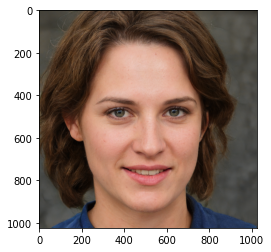

In [13]:
from matplotlib import pyplot as plt

# TODO: proper image displaying
for i in range(BATCH_SIZE):
    temp = images[i]
    temp = (temp + 1) * 127.5
    plt.imshow(temp.numpy().astype(np.uint8))
    break

## Train model

Layers & models also feature a boolean attribute trainable. Its value can be changed. Setting layer.trainable to False moves all the layer's weights from trainable to non-trainable.

In [14]:
class TransitionLayers(Layer):
  
  def __init__(self, num_filters):
    """Initialize a Transition Layer consisting of two Convolutional Layers (one acts as a Bottleneck, the other as Pooling Layer). 
    These Layers can be placed between the Dense Blocks in our DenseNet.

    Arguments:
      num_filters (list): Number of filters, one for each conv layer in our Transition Layer.
    """  

    # use the keyword super to allow our network to access the init() form the keras Layer class
    super(TransitionLayers, self).__init__()

    # extract filters
    self.filter1, self.filter2 = num_filters

    # define set of layers
    self.TransitionLayer = [
        BatchNormalization(),
        ELU(),                           
        Conv2D(filters=self.filter1, kernel_size=1, strides=1, padding="valid",  activation=None),
        BatchNormalization(),
        ELU(),
        Conv2D(filters=self.filter2, kernel_size=2, strides=2, padding="valid",  activation=None),
        Dropout(0.5)]

  @tf.function 
  def call(self, x, training=True):
    """Activate our Transition Layers by propagating the input through them

    Arguments:
      x (Tensor): Tensor containing the input to our Transition Layers
      training (Boolean): Indicates whether regularization methods should be used or not when calling the Transition Layer

    Returns:
      x (Tensor): Tensor containing the drive of the Transition Layers
    """
    for layer in self.TransitionLayer:
      x = layer(x, training = training)
    return x

In [15]:
class Block(Layer):

  def __init__(self, filter, growth_rate):
    """Initialize a Block with two Convolutional Layers (the first one acts a Bottleneck, the other is a normal 3x3 Convolutional Layer). 
    At the end of each Block, the input is concatenated to the Blocks output. Groups of Blocks are connected by Transition Layers.

    Arguments:
      filter (int): Defines number of filters for the Bottleneck Layer
      growth_rate (int): Defines the number of added channels per concatenation
    """  

    # use the keyword super to allow our network to access the init() from the keras Layer class
    super(Block, self).__init__()

    self.BlockLayers = [
        BatchNormalization(),
        ELU(),
        Conv2D(filters=filter, kernel_size=1, padding="valid",  activation=None),
        BatchNormalization(),
        ELU(),
        Conv2D(filters=growth_rate, kernel_size=3, padding="same",  activation=None)]

    # We use this layer to concatenate the input of a Block to its output
    self.concatenate = Concatenate()

  @tf.function 
  def call(self, x, training=True):
    """Activate one Block by propagating the input through the Block layer by layer

    Arguments:
      x (Tensor): Tensor containing the input to our Block
      training (Boolean): Indicates whether regularization methods should be used or not when calling the Block 

    Returns:
      x (Tensor): Tensor containing the concatenated feature maps
    """
    y = x

    for layer in self.BlockLayers:
      y = layer(y, training = training)

    # concatenate input to output
    y = self.concatenate([y,x])
    return y

In [30]:
class DenseBlock(Layer):

  def __init__(self, filter, growth_rate, num_blocks):
    """Initialize a DenseBlock consiting of several Blocks

    Arguments:
      filter (int): Defines number of filters for the Bottleneck Layer
      growth_rate (int): Defines the number of added channels per concatenation
      num_blocks (int): Number of consecutive Blocks
    """  

    # use the keyword super to allow our network to access the init() from the keras Layer class
    super(DenseBlock, self).__init__()

    self.DenseBlockLayers = [Block(filter, growth_rate) for _ in range(num_blocks)]


  @tf.function 
  def call(self, x, training=True):
    """Activate one DenseBlock by propagating the input through the DenseBlock layer by layer

    Arguments:
      x (Tensor): Tensor containing the input to our DenseBlock
      training (Boolean): Indicates whether regularization methods should be used or not when calling the DenseBlock 

    Returns:
      x (Tensor): Outputs the feature maps of a whole DenseBlock
    """

    for block in self.DenseBlockLayers:
      x = block(x, training = training)

    return x

In [31]:
class DenseNetwork(Model):

  def __init__(self):
    """Initialize a DenseNet with a variable amount of keras.Layers
    """  
    # use the keyword super to allow our network to access the init() form the keras Model class
    super(DenseNetwork, self).__init__()

    self.DenseNetLayers = [Conv2D(filters=32, kernel_size=3, padding="same",  activation=None)]

    self.DenseNetLayers.append(DenseBlock(filter=32, growth_rate=32, num_blocks=4))

    self.DenseNetLayers.append(TransitionLayers(num_filters=[32,64]))

    self.DenseNetLayers.append(DenseBlock(filter=64, growth_rate=64, num_blocks=4))

    self.DenseNetLayers.append(TransitionLayers(num_filters=[64,128]))

    self.DenseNetLayers.append(DenseBlock(filter=128, growth_rate=128, num_blocks=4))

    self.DenseNetLayers.extend([BatchNormalization(),
                                ELU(),
                                Conv2D(latent_size, 2, strides=2),
                                GlobalAveragePooling2D()])

    # TODO: Add last layer

  @tf.function    
  def call(self, x, training = True):
    """Activate our model propagating the input through the network layer by layer

    Arguments:
      x (Tensor): Tensor containing the input to our network
      training (Boolean): Indicates whether regularization methods should be used or not when calling the model 

    Returns:
      x (Tensor): Tensor containing the probabilities for the ten classes
    """

    for layer in self.DenseNetLayers:
      x = layer(x, training = training)
    return x

## Training preparation

## Load VGG and freeze it 

In [32]:
vgg = tf.keras.applications.VGG16()
# Freeze VGG since we don't want to train it
vgg.trainable = False

## Define perceptual loss

In [33]:
# TODO: tf.function
@tf.function
def perc_loss(real, fake, loss_tracker):
    # TODO: Better description. Also maybe more detail? Point to equation
    """Returns perceptual loss according to VGG16 activations. See 
    """
    
    real = tf.image.resize(real, [224, 224])
    real = tf.keras.applications.vgg16.preprocess_input(real)

    fake = tf.image.resize(fake, [224, 224])
    fake = tf.keras.applications.vgg16.preprocess_input(fake)
    
    for i, layer in enumerate(vgg.layers):
            real = layer(real)
            fake = layer(fake)
            # TODO: say which corresponds to what
            if i == 2 or i == 5 or i == 9 or i == 13 or i == 17:
                # normalize in channel dimension
                layer_loss = tf.math.l2_normalize(real, axis=-1)
                layer_loss -= tf.math.l2_normalize(fake, axis=-1)

                # TODO: should be alright, since shape is right, but not fully confirmed
                layer_loss = tf.norm(layer_loss, axis=-1)
                layer_loss = tf.square(layer_loss)
                layer_loss = tf.reduce_mean(layer_loss)

                loss_tracker.update_state(layer_loss)

In [34]:
# TODO
#@tf.function
def encoder_train_step(model, train_data, optimizer, global_loss_tracker, local_loss_tracker, train_writer):

    for inputs in train_data:
        
        # reset local loss
        local_loss_tracker.reset_states()    

        with tf.GradientTape() as tape:

            # perc
            fakes = model(inputs)
            fakes = get_img([fakes, labels], truncation_psi)
            perc_loss(inputs, fakes, local_loss_tracker)
            loss = local_loss_tracker.result()
            # average over the batch manually
            # TODO: remove
            #loss = tf.math.reduce_mean(loss)
            # TODO: remove
            print(model.__class_)
            gradients = tape.gradient(loss, model.trainable_variables)

        # update weights  
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

        # record global loss
        global_loss_tracker.update_state(loss)

## Instantiate loss trackers

In [35]:
GLOBAL_LOSS_TRACKER = tf.keras.metrics.Mean()
LOCAL_LOSS_TRACKER = tf.keras.metrics.Sum()

## Instantiate train writer

In [36]:
import datetime
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# Set log directory
LOG_DIR = "/content/drive/MyDrive/Lernen/Coxi/IANNwTF/logs/encoder/" + current_time 

TRAIN_WRITER = tf.summary.create_file_writer(LOG_DIR)

## Instantiate optimizer

In [37]:
LEARNING_RATE = 0.001
OPTIMIZER = tf.keras.optimizers.Adam(LEARNING_RATE)

## Instantiate encoder

In [38]:
ENCODER = DenseNetwork()

In [39]:
#for datum in data:
#    print(datum.shape)

In [40]:
# TODO: remove
#for datum in data:
#    ENCODER(datum)
#    break

# Train

In [42]:
NUM_EPOCHS = 10000

for epoch in range(NUM_EPOCHS):
    print("Start epoch: " + str(epoch))

    # reset statistics
    GLOBAL_LOSS_TRACKER.reset_states()

    encoder_train_step(ENCODER, data, OPTIMIZER, GLOBAL_LOSS_TRACKER, LOCAL_LOSS_TRACKER, TRAIN_WRITER)    
    data = data.shuffle(buffer_size = shuffle_size)

    # write average epoch loss
    with TRAIN_WRITER.as_default():
        tf.summary.scalar('loss', GLOBAL_LOSS_TRACKER.result(), step=epoch)    

Start epoch: 0


ResourceExhaustedError: ignored